In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop = set(stopwords.words('english'))
stop = stopwords.words('english')

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
from tensorflow.python.keras import regularizers

import torch

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [2]:
asleep_wheel = pd.read_csv('asleep_wheel_train.csv', index_col=[0])

In [3]:
asleep_wheel = asleep_wheel.fillna(0)

In [4]:
asleep_wheel = asleep_wheel[asleep_wheel['else'] == 0]

In [5]:
asleep_wheel = asleep_wheel[['lines', 'speech']]

In [6]:
asleep_wheel = asleep_wheel.replace('&', 0)

In [7]:
asleep_wheel.columns = ['lines', 'target']
asleep_wheel = asleep_wheel.reset_index(drop=True)

In [8]:
asleep_wheel['target'] = asleep_wheel['target'].astype(int)

In [9]:
asleep_wheel.target.value_counts(normalize=True)

1    0.663835
0    0.336165
Name: target, dtype: float64

In [10]:
asleep_wheel

,lines,target
0,"FOSTER, a woman in her mid-30’s sits at the ba...",0
1,"Foster, slightly buzzed, peruses the mostly fe...",0
2,"VINCE, mid-30’s, rugged, handsome, not too bri...",0
3,He holds a small pink dumbbell in his right ha...,0
4,"When he reaches chest level, his shoulder spas...",0
...,...,...
1643,. . . FIVE . . .,1
1644,The camera pans up to the sky.,0
1645,The screen fills with a bright white light.,0
1646,. . . Wide awake! Wide awake!,1


In [11]:
batman = pd.read_csv('Batman_test_set - Hoja 1.csv', index_col=[0])
batman

,lines,target
0,No response. Sunlight streams through wrought ...,0
1,What're you doing?!,1
2,Kidnapping you. They'' pay a lot for precious ...,1
3,"Young Bruce stares, wide-eyed. She SMILES. He ...",0
4,Young Bruce crouches in the mouth of a DISUSED...,0
...,...,...
296,"Rachel drives.\tBruce sits there, hands in his...",0
297,Are you okay?,1
298,All these years I wanted to kill him. Now he's...,1
299,You don't mean that.,1


In [12]:
meeseeks = pd.read_csv('meeseeks_test.csv', index_col=[0])

In [13]:
script = pd.concat([asleep_wheel, batman, meeseeks], ignore_index=True)

In [14]:
script = script.sample(frac=1)
script = script.reset_index(drop=True)

In [15]:
script

,lines,target
0,"SFX: Birds chirping, sounds of morning.",0
1,Why? Why are you doing this?,1
2,I don’t know.,1
3,"Okay, I know what I want. I didn’t before but ...",1
4,It’s romantic.,1
...,...,...
1975,Foster drives as Parker looks through Foster’s...,0
1976,"Seriously, after twelve times, you know, word ...",1
1977,Are you just not gonna talk to me? Is that it?,1
1978,"Here we go. Four. One, two, three. . .",1


In [16]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

script['length'] = script['lines'].apply(lambda x: length(x))

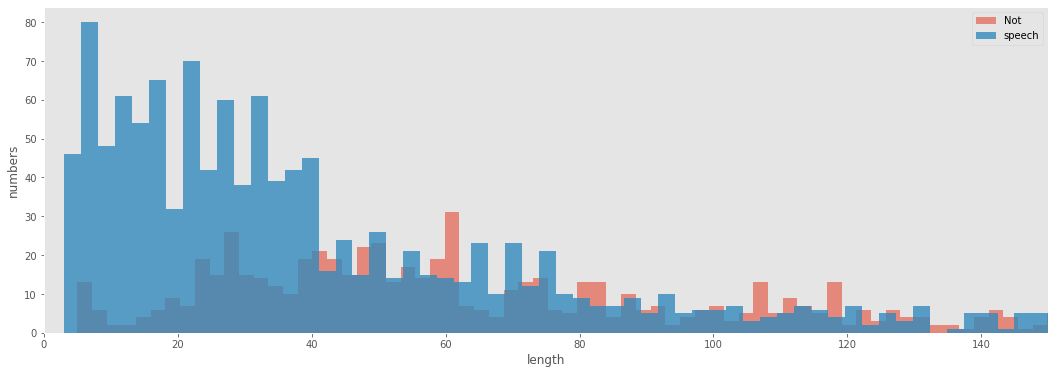

In [17]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 200
plt.hist(script[script['target'] == 0]['length'], alpha=0.6, bins=bins, label='Not')
plt.hist(script[script['target'] == 1]['length'], alpha=0.8, bins=bins, label='speech')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0, 150)
plt.grid()
plt.show()

In [18]:
# Remove punctuation and lower
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

script['lines'] = script['lines'].apply(lambda x : remove_punct(x.lower()))

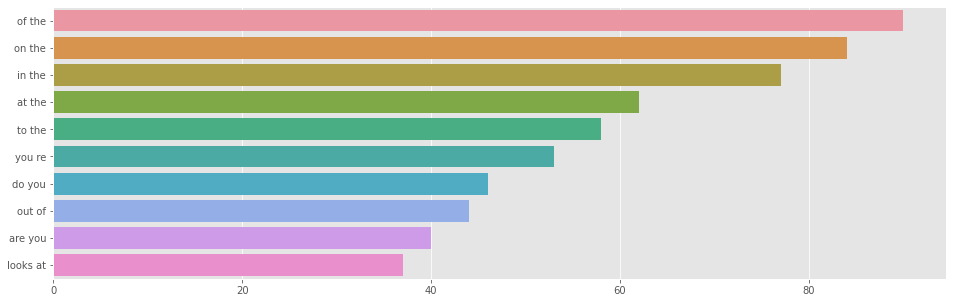

In [19]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(16,5))
top_bigrams = get_top_bigrams(script['lines'])[:10]
x, y = map(list, zip(*top_bigrams))
sns.barplot(x=y, y=x);

Text(0.5, 0.98, 'Average word length in each line')

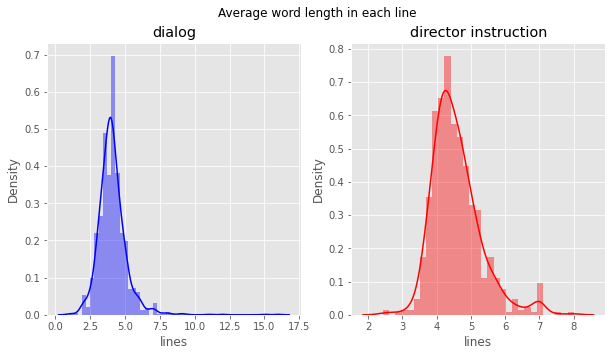

In [20]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
word = script[script['target'] == 1]['lines'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='blue')
ax1.set_title('dialog')
word = script[script['target'] == 0]['lines'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='red')
ax2.set_title('director instruction')
fig.suptitle('Average word length in each line')

In [21]:
def create_corpus(target):
    corpus=[]
    
    for x in script[script['target'] == target]['lines'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def create_corpus_df(script, target):
    
    corpus = []
    
    for x in script[script['target'] == target]['lines'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus = create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:10]

In [22]:
np.array(stop)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

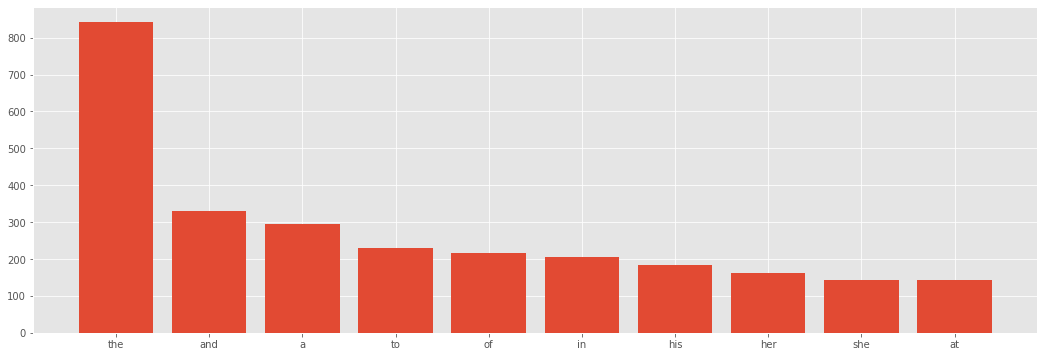

In [23]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x, y = zip(*top)
plt.bar(x, y);

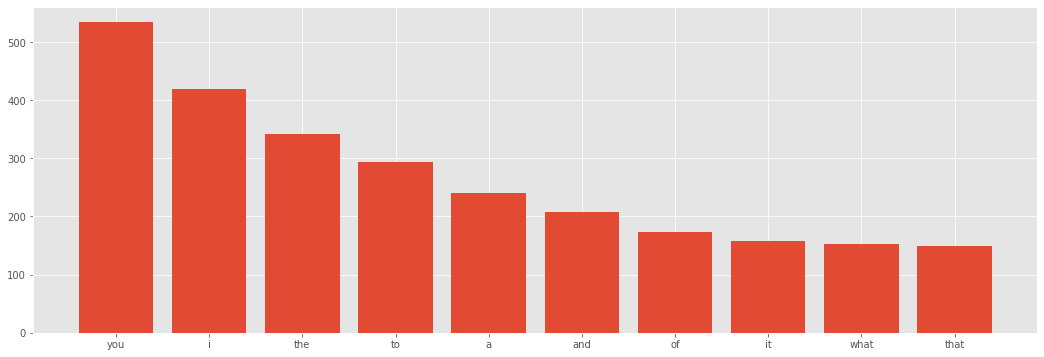

In [24]:
corpus = create_corpus(1)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x, y= zip(*top)
plt.bar(x, y);

In [25]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = script["lines"].tolist()
list_labels = script["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=42)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

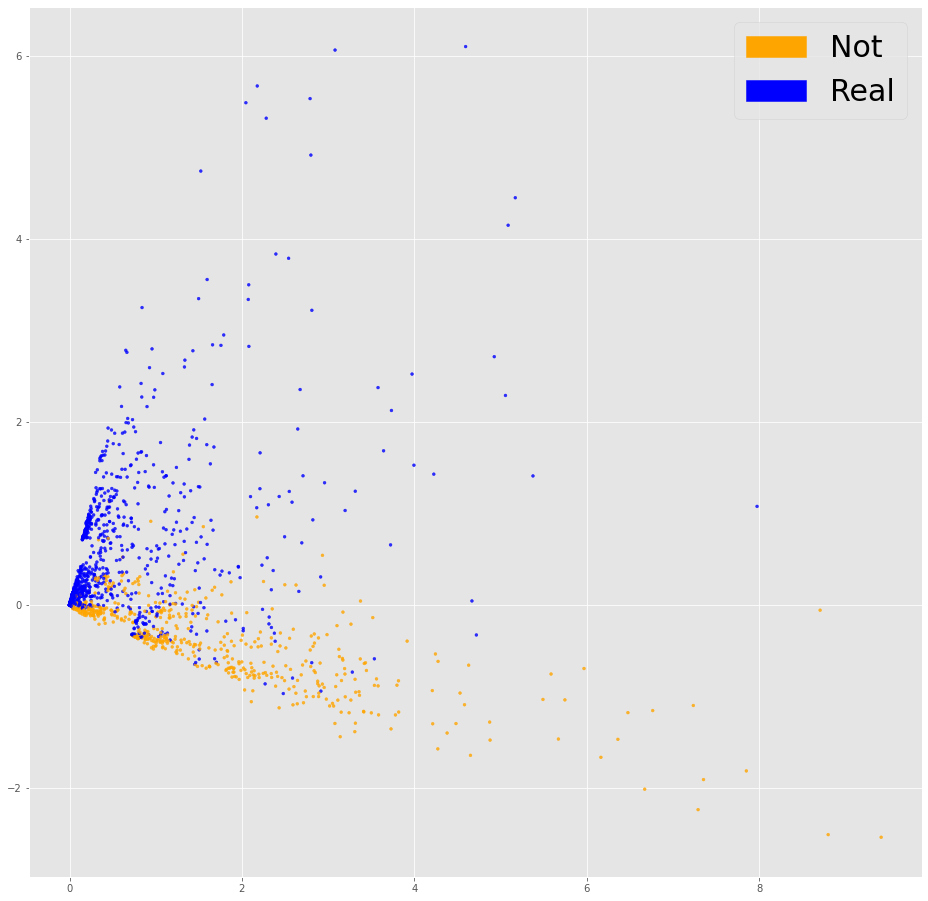

In [26]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_counts, y_train)
plt.show()

In [27]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

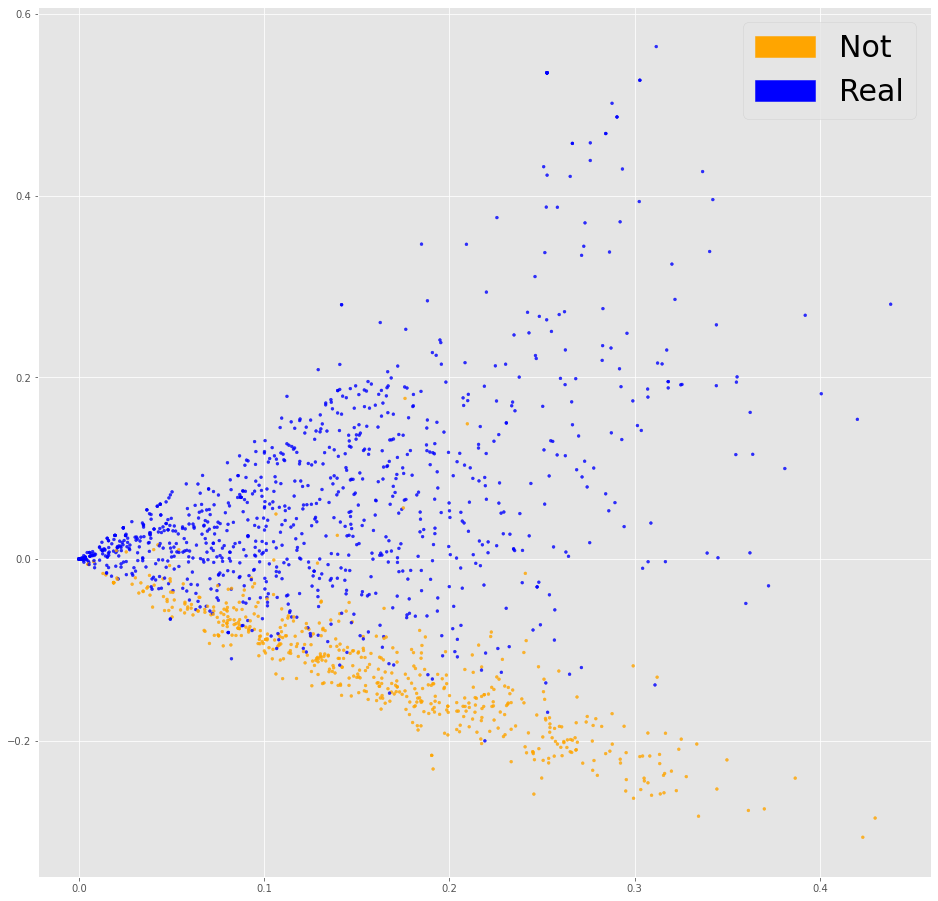

In [28]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [29]:
# Remove stop words
script['lines'] = script['lines'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [30]:
def create_corpus_new(script):
    corpus = []
    for line in tqdm(script['lines']):
        words = [word.lower() for word in word_tokenize(line)]
        corpus.append(words)
    return corpus   

In [31]:
corpus = create_corpus_new(script)

100%|██████████| 1980/1980 [00:00<00:00, 10901.58it/s]


In [32]:
embedding_dict = {}
with open('/Users/robinmasliah/Documents/GitHub/NLP/Disaster tweets/glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
f.close()

In [33]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

corpus_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [34]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 3406


In [35]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec 

100%|██████████| 3406/3406 [00:00<00:00, 476431.53it/s]


In [36]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


%%time
with strategy.scope():
    # define model
    model = keras.Sequential()
    model.add(layers.Embedding(num_words, 100, input_length=50))
    model.add(layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimzer = Adam(learning_rate=3e-4)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   

    print(model.summary())

In [37]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
    model = keras.Sequential()
    model.add(layers.Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix), 
                    input_length=MAX_LEN, trainable=False))
    model.add(layers.SpatialDropout1D(0.7))
    model.add(layers.LSTM(200, dropout=0.4, recurrent_dropout=0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimzer = Adam(learning_rate=3e-4)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           340700    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 581,701
Trainable params: 241,001
Non-trainable params: 340,700
_________________________________________________________________
CPU times: user 136 ms, sys: 8.42 ms, total: 145 ms
Wall time: 139 ms


In [38]:
X_train, X_test, y_train, y_test = train_test_split(corpus_pad, script['target'].values, test_size=0.2)
print('Shape of train', X_train.shape)
print("Shape of Validation ", X_test.shape)

Shape of train (1584, 50)
Shape of Validation  (396, 50)


In [39]:
history = model.fit(X_train, y_train, batch_size=9, epochs=12, validation_data=(X_test, y_test), verbose=1)

Epoch 1/12
176/176 [==============================] - 10s 50ms/step - loss: 0.5976 - accuracy: 0.7073 - val_loss: 0.7095 - val_accuracy: 0.4268
Epoch 2/12
176/176 [==============================] - 8s 47ms/step - loss: 0.6470 - accuracy: 0.6068 - val_loss: 0.6588 - val_accuracy: 0.6364
Epoch 3/12
176/176 [==============================] - 8s 47ms/step - loss: 0.6591 - accuracy: 0.6447 - val_loss: 0.5926 - val_accuracy: 0.6490
Epoch 4/12
176/176 [==============================] - 8s 48ms/step - loss: 0.5673 - accuracy: 0.6921 - val_loss: 0.3269 - val_accuracy: 0.8687
Epoch 5/12
176/176 [==============================] - 9s 48ms/step - loss: 0.5126 - accuracy: 0.7732 - val_loss: 0.3009 - val_accuracy: 0.8813
Epoch 6/12
176/176 [==============================] - 8s 48ms/step - loss: 0.4753 - accuracy: 0.7908 - val_loss: 0.3777 - val_accuracy: 0.9066
Epoch 7/12
176/176 [==============================] - 8s 48ms/step - loss: 0.4371 - accuracy: 0.8203 - val_loss: 0.2573 - val_accuracy: 0.919

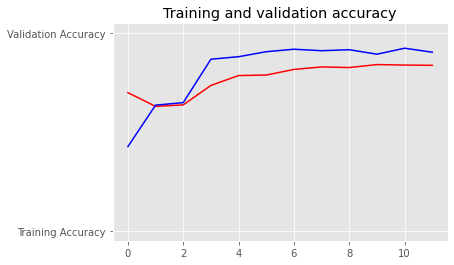

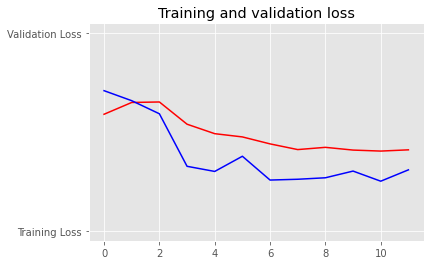

<Figure size 432x288 with 0 Axes>

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure();
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure();

In [41]:
test_pred_GloVe = model.predict(X_test)
test_pred_GloVe_int = test_pred_GloVe.round().astype('int')

In [42]:
test_pred_GloVe_int.shape

(396, 1)

In [43]:
test_pred_GloVe_int
test_pred_GloVe_int = [item for sublist in test_pred_GloVe_int for item in sublist]

In [44]:
y_test = list(y_test)

In [45]:
# evaluate
loss, acc = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 90.404040


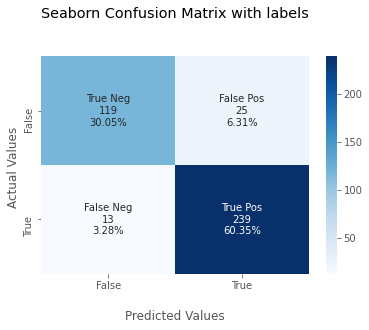

In [46]:
def plot_confusion_matrix(y_test, y_pred):
    
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
plot_confusion_matrix(y_test, test_pred_GloVe_int)

In [47]:
# Guardar el Modelo
model.save('/Users/robinmasliah/Documents/GitHub/NLP/speech_vs_narrative/model/lstm_dialog_def_model.h5')

In [48]:
# Recrea exactamente el mismo modelo solo desde el archivo
new_model = keras.models.load_model('/Users/robinmasliah/Documents/GitHub/NLP/speech_vs_narrative/model/lstm_dialog_def_model.h5')

In [49]:
script = pd.read_csv('12yslave_21jump.csv', index_col=[0])
script['lines'] = script['lines'].apply(lambda x : remove_punct(x.lower()))
script['lines'] = script['lines'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [50]:
script

,lines,target
0,okay see you’re going let’s work get,1
1,pan find clint barton daughter lila coaching n...,0
2,okay good tip bow arm three fingers,1
3,three,1
4,guys want mustard mayo,1
...,...,...
96,else supposed call someone mexico,1
97,cholita stares jenko defiant,0
98,five mexican bangers stare across table jesus ...,0
99,jenko winks schmidt,0


In [51]:
corpus = create_corpus_new(script)

100%|██████████| 101/101 [00:00<00:00, 9775.35it/s]


In [52]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

corpus_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [53]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 574


In [54]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec 

100%|██████████| 574/574 [00:00<00:00, 227770.15it/s]


In [55]:
test_pred_GloVe = model.predict(corpus_pad)
test_pred_GloVe_int = test_pred_GloVe.round().astype('int')
print(test_pred_GloVe_int.shape)

(101, 1)


In [56]:
test_pred_GloVe_int = [item for sublist in test_pred_GloVe_int for item in sublist]

In [57]:
y_test = list(script.target)

In [58]:
len(y_test)

101

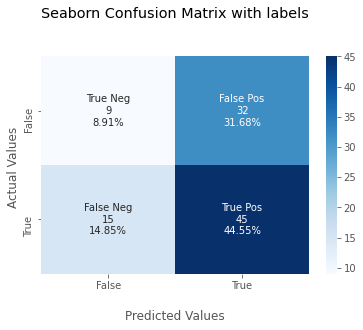

In [59]:
plot_confusion_matrix(y_test, test_pred_GloVe_int)